In [3]:
#Importing packages
import osmnx as ox
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats
from sklearn.preprocessing import minmax_scale
import powerlaw
import os

In [6]:
#Importing shape files
sheff_OShighways = geopandas.read_file(os.path.join(os.environ['USERPROFILE'] + r"\Dropbox\PIN\1 Data\1 Data\Workshop_2_data\Sheffield_OA.shp"))
#sheff = geopandas.read_file(r"C:\Users\cip18jjp\Dropbox\PIN\1 Data\1 Data\Workshop_2_data\Sheffield_Network.gdb")
sheff_lsoa_shape = geopandas.read_file(os.path.join(os.environ['USERPROFILE'] + r"\Dropbox\PIN\1 Data\1 Data\CDRC\Census Data Pack\Sheffield\shapefiles\Sheffield_lsoa11.shp"))
sheff_msoa_shape = geopandas.read_file(os.path.join(os.environ['USERPROFILE'] + r"\Dropbox\PIN\1 Data\1 Data\CDRC\Census Data Pack\Sheffield\shapefiles\Sheffield_msoa11.shp"))

In [8]:
#Import Population data
sheff_lsoa_pop = geopandas.read_file(os.path.join(os.environ['USERPROFILE'] + r"\Dropbox\PIN\1 Data\1 Data\CDRC\Census Data Pack\Sheffield\tables\KS101EW_lsoa11.csv"))
sheff_lsoa_pop['KS101EW0001'] = pd.to_numeric(sheff_lsoa_pop['KS101EW0001']) #Count: All categories:sex

In [10]:
#Income Distributions
sheff_lsoa_income = geopandas.read_file(os.path.join(os.environ['USERPROFILE'] + r"\Dropbox\PIN\1 Data\1 Data\CDRC\Individual LSOA Income Estimate\E37000040\spatial\E37000040.shp"))

#Remove lsoa's that aren't in census data so income & pop are same size
ids = sheff_lsoa_income['lsoa11cd'].isin(sheff_lsoa_pop['GeographyCode'].values)
ids = np.where(ids==True)
sheff_lsoa_income = sheff_lsoa_income.iloc[ids]

#Indexing 25 evenly spaced from array
idx = np.round(np.linspace(0, len(sheff_lsoa_income) - 1, 25)).astype(int)

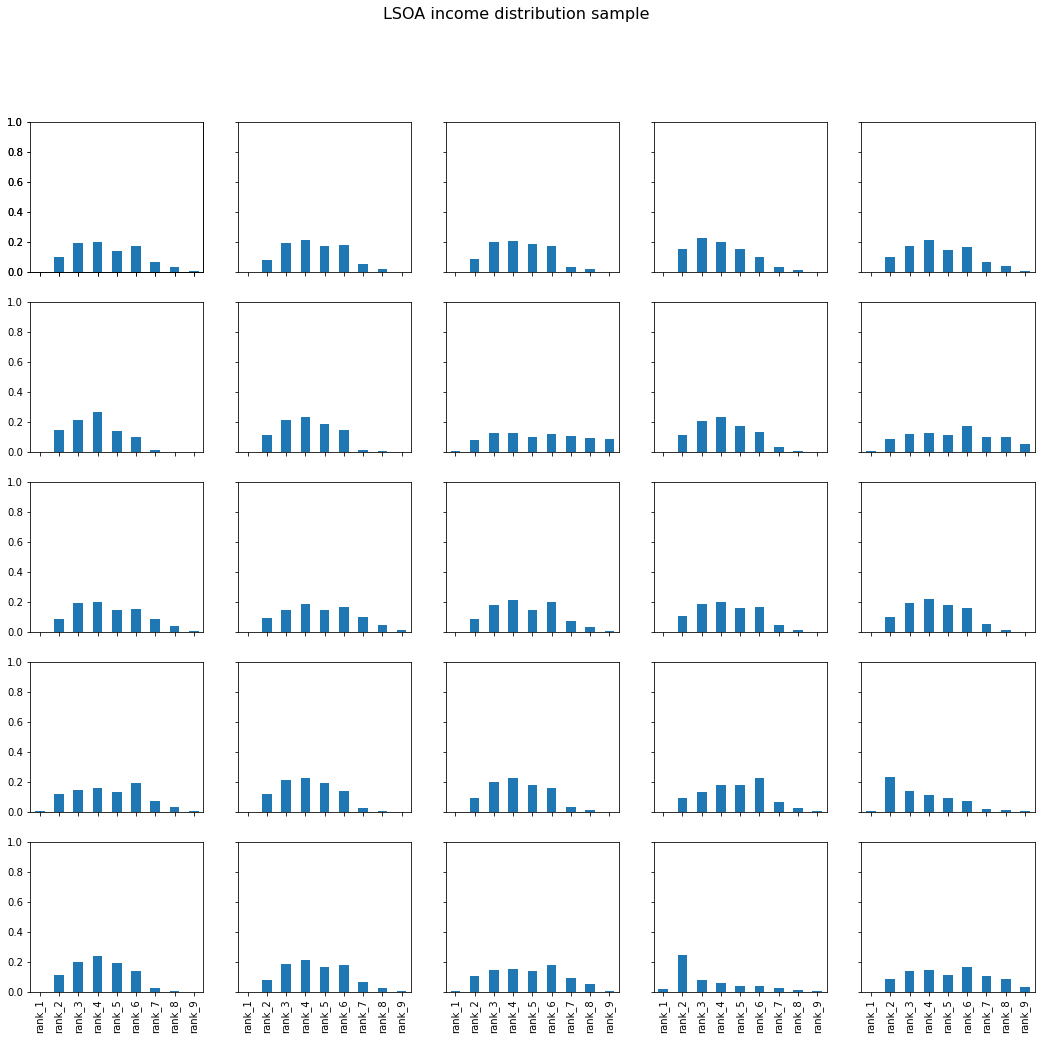

In [11]:



fig = plt.figure(figsize=(18,16))
fig.suptitle('LSOA income distribution sample', fontsize=16)
ax0 = fig.add_subplot(5,5,1)
for i in range(len(idx)):
    ax = fig.add_subplot(5,5,i+1, sharex = ax0, sharey = ax0)
    ax = sheff_lsoa_income.iloc[idx[i]]['rank_1':'rank_9'].plot.bar()
    ax.set_ylim(0,1)
#fig.savefig(r'C:\Users\cip18jjp\Dropbox\PIN\Temp\LSOA_income_distributions.pdf', format = 'pdf')

C:\Users\jorda\Anaconda3\envs\ox\lib\site-packages\scipy\stats\_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\jorda\Anaconda3\envs\ox\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\jorda\Anaconda3\envs\ox\lib\site-packages\scipy\stats\_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\jorda\Anaconda3\envs\ox\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\jorda\Anaconda3\envs\ox\lib\site-packages\scipy\stats\_continuous_distns.py:515: RuntimeWarning: inva

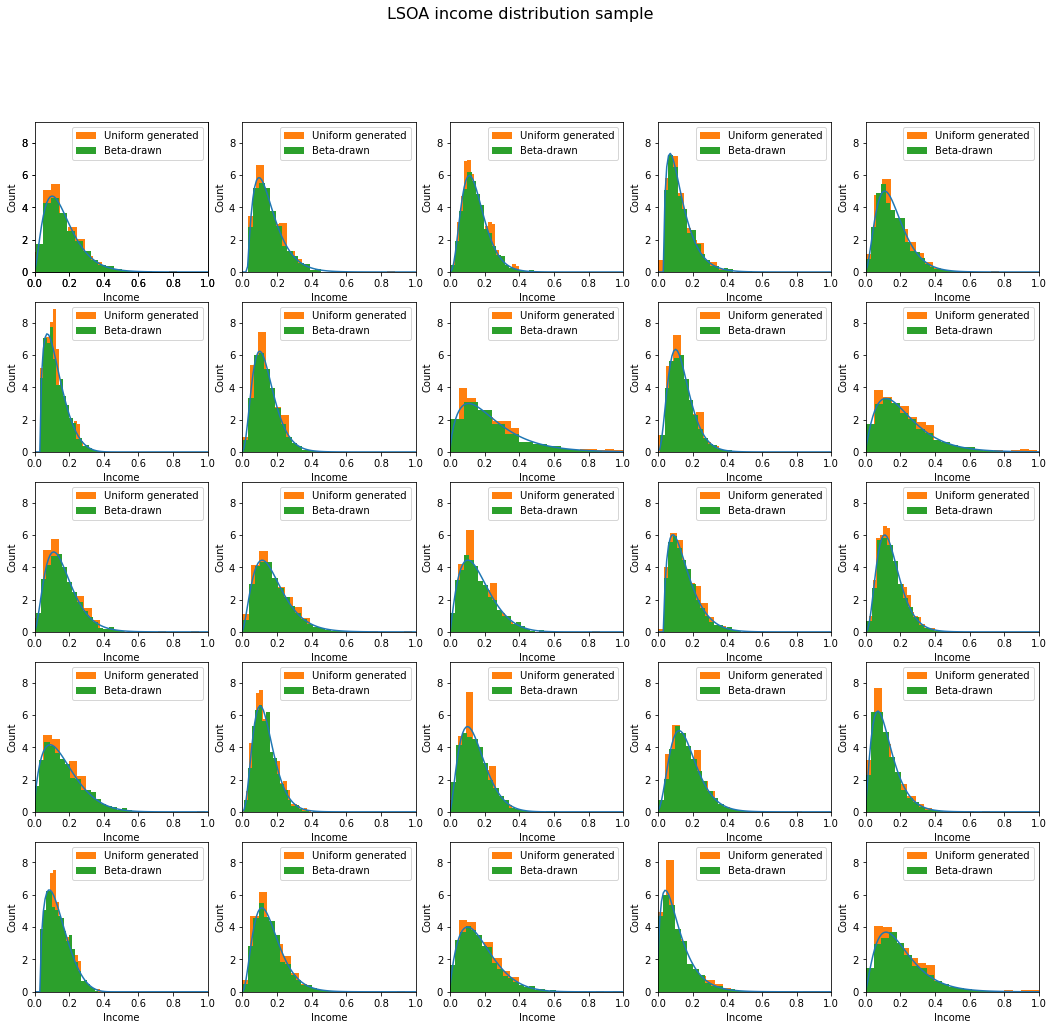

In [12]:
#Creating empirical income distributions

"""
Counts used are those we have data for in terms of income. The same counts are then used in education sampling. 
"""

bounds = [0, 5000, 10000, 15000, 20000, 30000, 40000, 50000, 60000, 150000] #income bounds
bounds = minmax_scale(bounds)

income_dists=[]
counts=[]

b_params = np.zeros((len(idx), 4))
bin_no = 20



fig = plt.figure(figsize=(18,16))
fig.suptitle('LSOA income distribution sample', fontsize=16)
ax0 = fig.add_subplot(5,5,1)

for i in range(len(idx)):
    count = sheff_lsoa_pop['KS101EW0001'].values[idx[i]]
    count = count * sheff_lsoa_income.iloc[idx[i]]['rank_1':'rank_9'].values
    count = count.astype(int)
    ax = fig.add_subplot(5,5,i+1, sharex = ax0, sharey = ax0)
    x = []
    for j in range(len(count)):
        if j == 0:
            x.append(np.random.uniform(low = bounds[j], high = bounds[j], size = count[j]))
        else:
            x.append(np.random.uniform(low = bounds[j], high = bounds[j + 1], size = count[j]))
    x = np.concatenate(x, axis = 0)
    
    #Create list of counts to use later
    counts.append(sum(count))
       
    #Fitting beta functions
    b_params[i, 0], b_params[i, 1], b_params[i, 2], b_params[i, 3] = stats.beta.fit(x, loc = 0, scale = 1)
    ax.plot(np.linspace(0,1,100),  stats.beta.pdf(np.linspace(0,1,100), b_params[i, 0], b_params[i, 1], loc = b_params[i, 2], scale = b_params[i, 3]) )
    
    #Generating Income dists
    income_dists.append(stats.beta.rvs(b_params[i, 0], b_params[i, 1], loc = b_params[i, 2], scale = b_params[i, 3], size=sheff_lsoa_pop['KS101EW0001'].values[idx[i]].astype(int)))
    
    #Generating plots
    ax.hist(x, bins = bin_no, density = True, label = 'Uniform generated')
    ax.hist(income_dists[i], bins = bin_no, density = True, label = 'Beta-drawn')
    ax.legend(loc='upper right')
    ax.set_ylabel("Count")
    ax.set_xlabel("Income")
    ax.set_xlim(0,1)

#fig.savefig(r'C:\Users\cip18jjp\Dropbox\PIN\Temp\LSOA_income_distributions.pdf', format = 'pdf')    


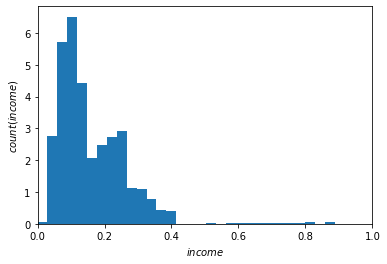

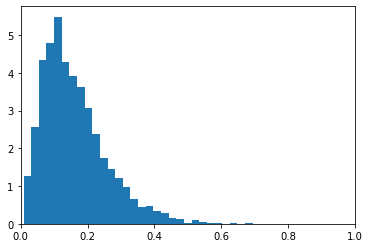

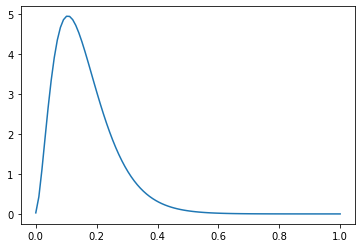

In [325]:
#Fitting beta distribution to the above
bin_no = 30
plt.figure()
plt.hist(income_dists[0], bins = bin_no, density = True)
plt.ylabel(r'$count(income)$')
plt.xlabel(r'$income$')
plt.xlim(0,1)
a1, b1, loc1, scale1 = stats.beta.fit(income_dists[0], loc = 0, scale = 1)

R = stats.beta.rvs(a1, b1, loc = loc1, scale = scale1, size = 2500)
plt.figure()
plt.hist(R, bins = bin_no, density = True)
plt.xlim(0,1)

plt.figure()
plt.plot(np.linspace(0,1,100),  stats.beta.pdf(np.linspace(0,1,100), a1, b1, loc = loc1, scale = scale1) )

In [313]:
count = sheff_lsoa_pop['KS101EW0001'].values[0]
count = count * sheff_lsoa_income.iloc[0]['rank_1':'rank_9'].values
count = count.astype(int)
sheff_lsoa_pop['KS101EW0001'].values[0]


1658

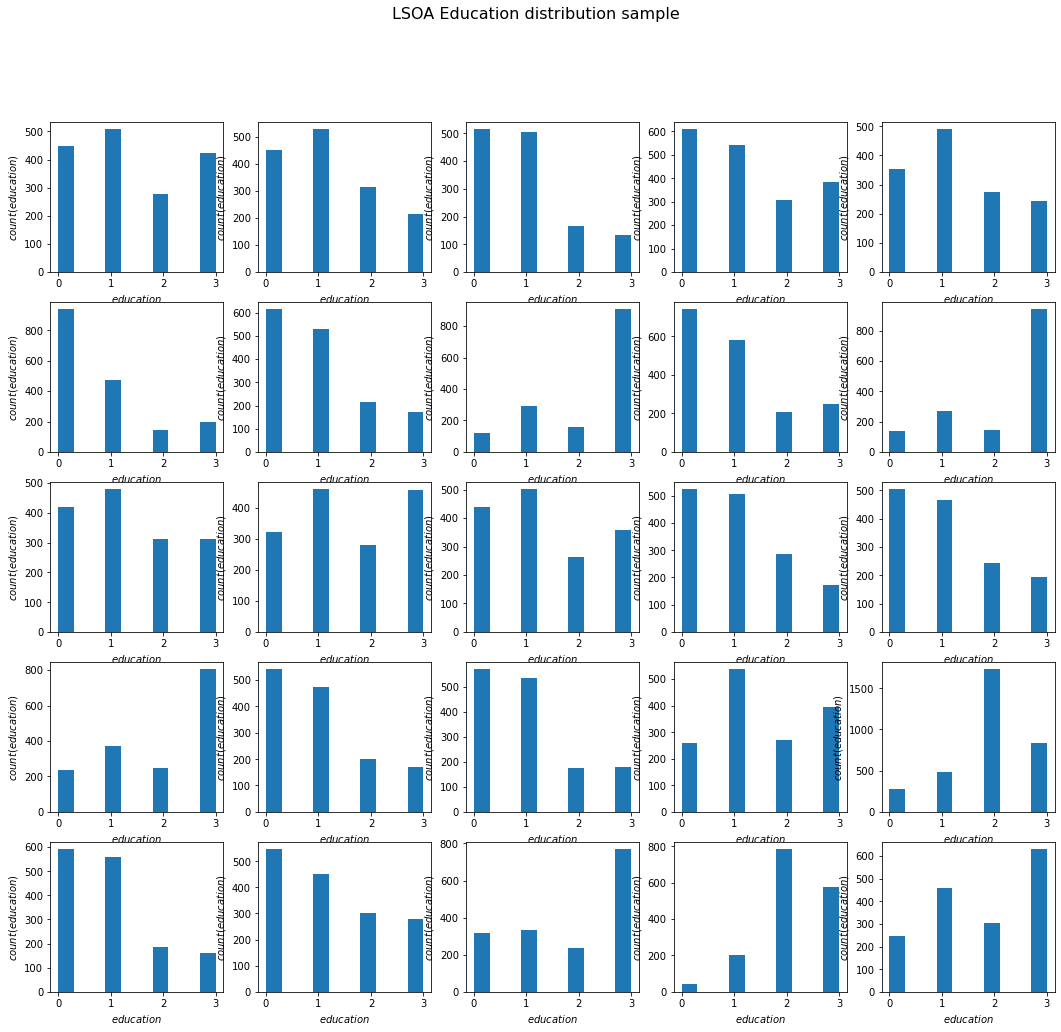

In [19]:
#Education Distribution
"""
Find in the atlas.
"""

sheff_lsoa_education = geopandas.read_file(os.path.join(os.environ['USERPROFILE'] + r"\Dropbox\PIN\1 Data\1 Data\CDRC\Census Data Pack\Sheffield\tables\KS501EW_lsoa11.csv"))

education=[]
#Indexing 25 evenly spaced from array
idx = np.round(np.linspace(0, len(sheff_lsoa_education) - 1, 25)).astype(int)

fig = plt.figure(figsize=(18,16))
fig.suptitle('LSOA Education distribution sample', fontsize=16)

for i in range(len(idx)):
    count = sheff_lsoa_pop['KS101EW0001'].values[idx[i]].astype(int)
    edu = sheff_lsoa_education.iloc[idx[i]][[2,3,4,5,6,7]].values.astype(int)
    levels = [edu[0], edu[1]+edu[2], edu[3] + edu[4], edu[5]]
    edu = sum(sheff_lsoa_education.iloc[idx[i]][[2,3,4,5,6,7]].values.astype(int))
    ratios = np.divide(levels,edu)
    
    education.append(np.random.choice(4, size = count, p=ratios)) #where p values are effectively the ratio of people with a given education level you can alternatively use the same method for income as well
    ax = fig.add_subplot(5,5,i+1)
    ax.hist(education[i])
    ax.set_ylabel(r'$count(education)$')
    ax.set_xlabel(r'$education$')    
    

#fig.savefig(r'C:\Users\cip18jjp\Dropbox\PIN\Temp\LSOA_education_distributions.pdf', format = 'pdf')    

Text(0.5, 0, '$education$')

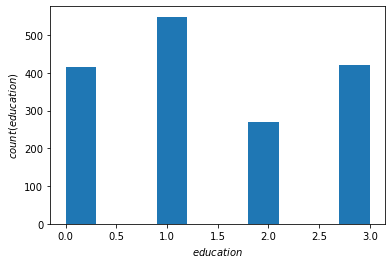

In [146]:
#Education Distributions
"""
Sum of: No quals, level 1, level 2, level 3 and level 4. Ignore "other qualifications" and "apprenticeships". 
"""
count = sheff_lsoa_pop['KS101EW0001'].values[idx[0]].astype(int)
edu = sheff_lsoa_education.iloc[idx[0]][[2,3,4,5,6,7]].values.astype(int)
levels = [edu[0], edu[1]+edu[2], edu[3] + edu[4], edu[5]]
edu = sum(sheff_lsoa_education.iloc[idx[0]][[2,3,4,5,6,7]].values.astype(int))
ratios = np.divide(levels,edu)

education=np.random.choice(4, size = count, p=ratios) #where p values are effectively the ratio of people with a given education level you can alternatively use the same method for income as well
plt.figure()
plt.hist(education)
plt.ylabel(r'$count(education)$')
plt.xlabel(r'$education$')

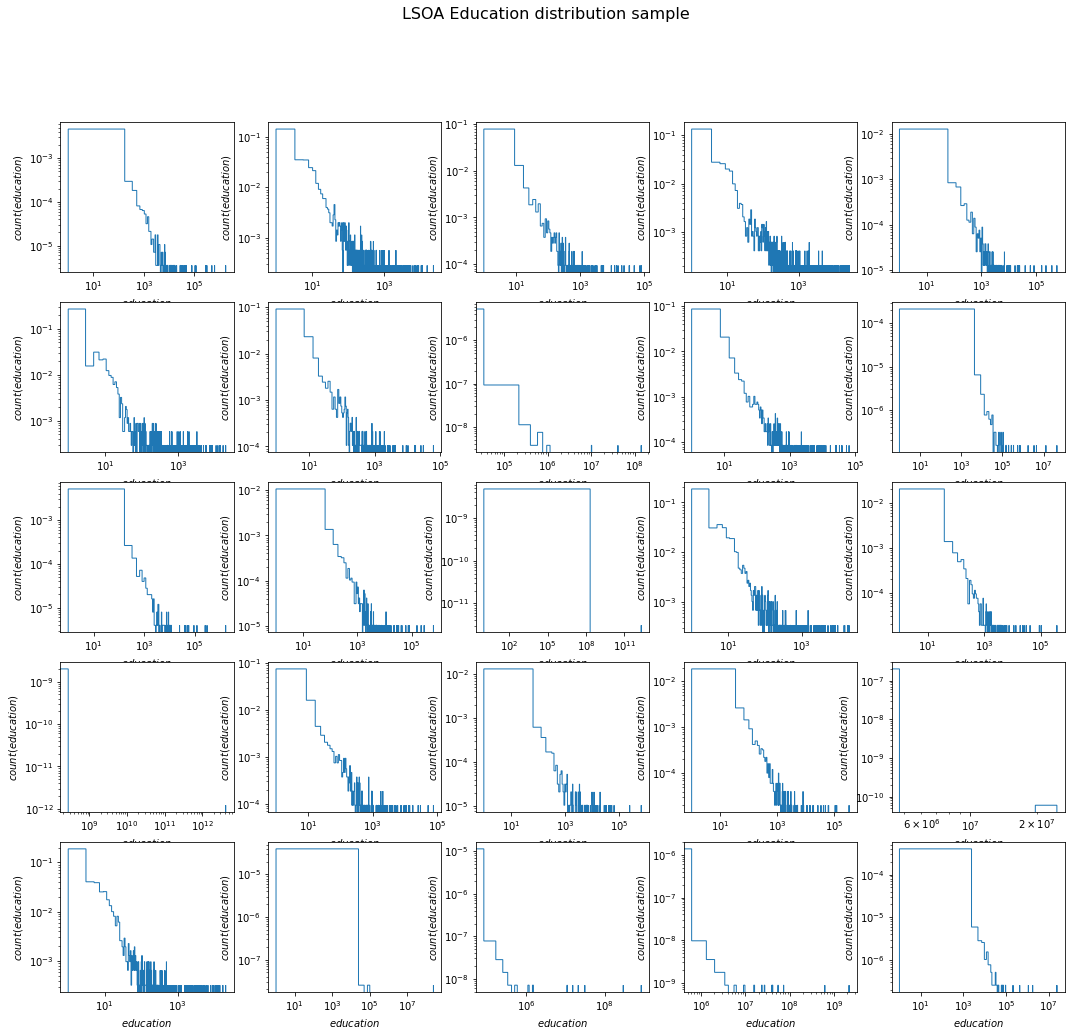

In [18]:
#Attractivity
attractivity = []


fig = plt.figure(figsize=(18,16))
fig.suptitle('LSOA Attractivity distribution sample', fontsize=16)


for i in range(len(idx)):
    attractivity.append(np.power(income_dists[i], -education[i]))
    
    ax = fig.add_subplot(5,5,i+1)
    ax.hist(attractivity[i], bins=10000, density=True, histtype='step')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel(r'$count(education)$')
    ax.set_xlabel(r'$education$')       

Calculating best minimal value for power law fit
C:\Users\jorda\Anaconda3\envs\ox\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


Text(0.5, 0, '$attractivity$')

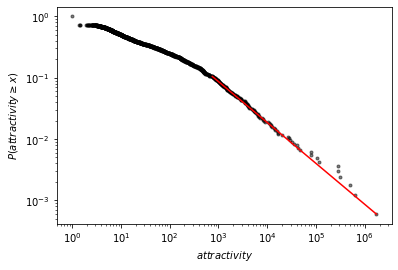

In [21]:
attractivtiy_powerlaw = powerlaw.Fit(attractivity[0])
attractivtiy_powerlaw_temp = powerlaw.Fit(attractivity[0], xmin=1)
plt.figure()
powerlaw_plot=attractivtiy_powerlaw_temp.plot_ccdf(original_data=True, color='k', marker='.', lw=0, alpha=0.5)
X=attractivtiy_powerlaw_temp.ccdf()
x=X[0][X[0]>=attractivtiy_powerlaw.xmin]
y=[np.exp( (-(attractivtiy_powerlaw.alpha-1)*(np.log(i)-np.log(attractivtiy_powerlaw.xmin))+np.log(X[1][X[0]==attractivtiy_powerlaw.xmin])) ) for i in x]
plt.plot(x, y, 'r')
plt.ylabel(r'$P(attractivity \geq x)$')
plt.xlabel(r'$attractivity$')

Calculating best minimal value for power law fit
C:\Users\jorda\Anaconda3\envs\ox\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit
C:\Users\jorda\Anaconda3\envs\ox\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit
C:\Users\jorda\Anaconda3\envs\ox\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit
C:\Users\jorda\Anaconda3\envs\ox\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit
C:\Users\jorda\Anaconda3\envs\ox\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /
Calculating best minimal value for power

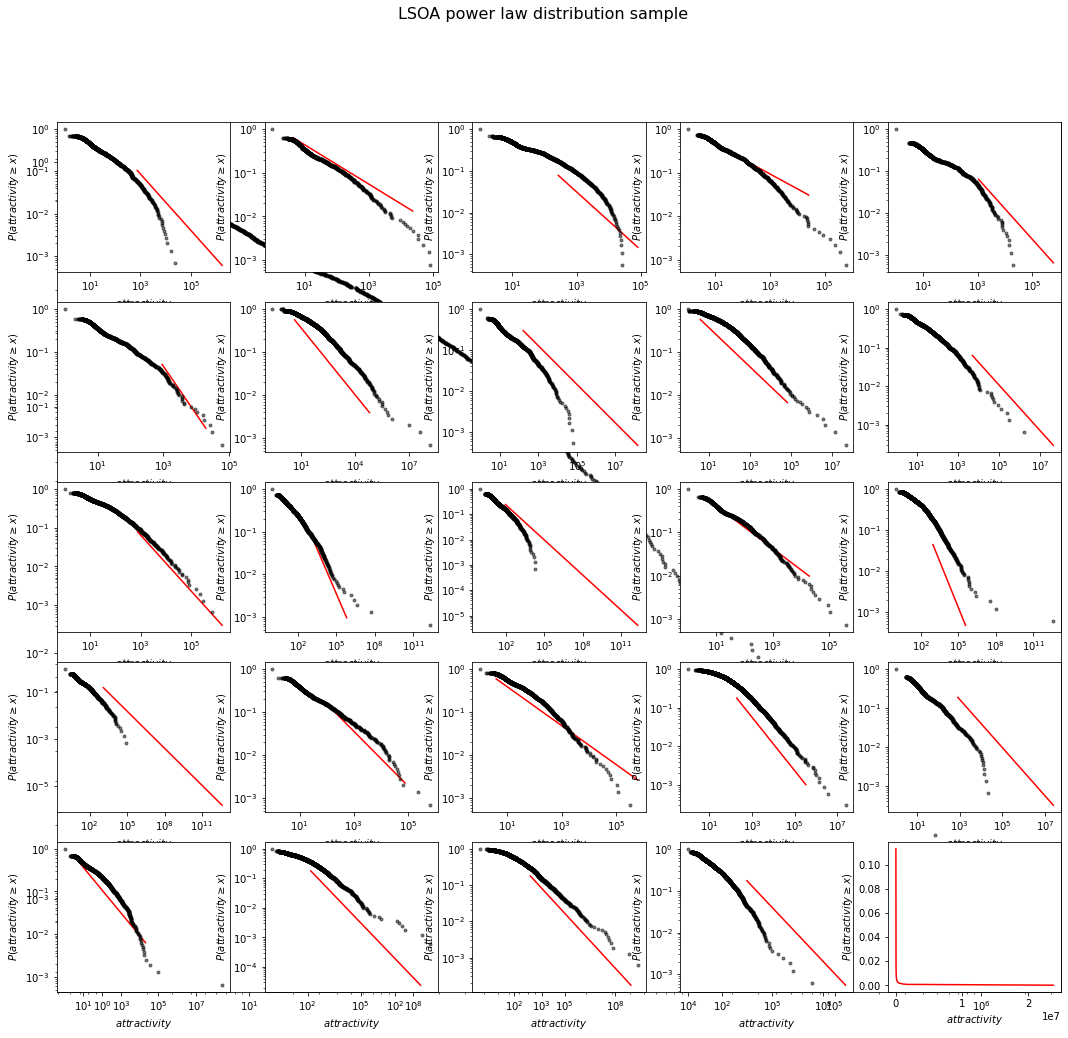

In [24]:
fig = plt.figure(figsize=(18,16))
fig.suptitle('LSOA power law distribution sample', fontsize=16)


for i in range(len(idx)):
    attractivtiy_powerlaw = powerlaw.Fit(attractivity[i])
    
    attractivtiy_powerlaw_temp = powerlaw.Fit(attractivity[i], xmin=1)
    
    powerlaw_plot=attractivtiy_powerlaw_temp.plot_ccdf(original_data=True, color='k', marker='.', lw=0, alpha=0.5)
    
    X=attractivtiy_powerlaw_temp.ccdf()
    x=X[0][X[0]>=attractivtiy_powerlaw.xmin]
    y=[np.exp( (-(attractivtiy_powerlaw.alpha-1)*(np.log(i)-np.log(attractivtiy_powerlaw.xmin))+np.log(X[1][X[0]==attractivtiy_powerlaw.xmin])) ) for i in x]
    
    ax = fig.add_subplot(5,5,i+1)
    ax.plot(x, y, 'r')
    ax.set_ylabel(r'$P(attractivity \geq x)$')
    ax.set_xlabel(r'$attractivity$')